# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200612/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/2018/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v0/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v1/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v2/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/'

os.system("mkdir -p "+ plotDir)

0

# Loading

In [3]:
# home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/'
# home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200805/v1/'
# home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200805/v2/'
home_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200805/v3/'
SignalInput = 'CTAUSignalSummaryTableBin2Rebin.txt'
OLDSignalInput = 'SignalSummaryTableBin2Rebin.txt' #1000 mm
DataInput = 'PredictionSummaryTableBin2Rebin.txt'

In [4]:

years = []
years = [
            '2016',
            '2017',
            '2018',
]

data_bin2 = {}
data_bin2err = {}

data_f=open(home_dir+DataInput, 'r')
for data_l in data_f:
    
    if 'Data' in data_l:
        data_ws = data_l.split('|')
        
#         print('sample year',data_ws[1].split(' ')[2])
#         print('bin 2 prediction ' , data_ws[3].lstrip(' ').rstrip(' '))
#         print('bin 2 error ', data_ws[4].lstrip(' ').rstrip(' '))
        
        year = data_ws[1].split(' ')[2]
        bin2 = float(data_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(data_ws[4].lstrip(' ').rstrip(' '))
        
#         print(type(year))
#         print(type(bin2))
#         print(type(bin2err))
        
        data_bin2[year] = bin2
        data_bin2err[year] = bin2err
        
#         print('sample year',len(data_ws[1].split(' ')[2]))
#         print('bin 2 prediction ' , len(data_ws[3].lstrip(' ').rstrip(' ')))
#         print('bin 2 error ', len(data_ws[4].lstrip(' ').rstrip(' ')))
        
#         var = data_ws[1].split(' ')[2]
#         var = data_ws[3].lstrip(' ').rstrip(' ')
#         var = data_ws[4].lstrip(' ').rstrip(' ')
#         for j in range(len(var)):
#             print(var[j])

#         for data_w in data_ws:
# #             print(data_w)
#             print(data_w.lstrip(' '))
data_f.close()



In [5]:
data_f=open(home_dir+DataInput, 'r')
print(data_f.read())
data_f.close()

data_bin2_sum = 0
data_bin2_sum_err_tmp = 0
for year in years:
    print(year, data_bin2[year], data_bin2err[year])
    data_bin2_sum += data_bin2[year]
    data_bin2_sum_err_tmp += pow(data_bin2err[year],2)

data_bin2_sum_err = round(math.sqrt(data_bin2_sum_err_tmp),2)

print('Data sum',data_bin2_sum)
print('Data sum err',data_bin2_sum_err)


+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
|   Sample  | method | Bin 2 Prediction | Bin 2 Prediction Error | Bin 2 Prediction Error Up | Bin 2 Prediction Error Low |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
| Data 2018 | 1D pt  |       0.58       |          0.26          |            0.35           |            0.18            |
| Data 2017 | 1D pt  |       0.88       |          0.45          |            0.61           |            0.29            |
| Data 2016 | 1D pt  |       1.47       |          0.58          |            0.74           |            0.41            |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
2016 1.47 0.58
2017 0.88 0.45
2018 0.58 0.26
Data sum 2.93
Data sum err 0.78


In [6]:
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, ])
# ctaus=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1,3,5,7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1,3,5,7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1500, 2000, 3000, 4000, 5000, 10000])
# ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
ctaus=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000])
OLD_CTAU=1000 #mm

In [7]:
# CTAUs = np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000]) #mm
# CTAUs=np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([1,3,5,7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
CTAUs=np.array([1, 3, 5, 7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000])

sig_bin2 = {}
sig_bin2err = {}

for year in years:
    sig_bin2[year] = {}
    sig_bin2err[year] = {}

sig_f=open(home_dir+SignalInput, 'r')
for sig_l in sig_f:
    
    if 'H(bb)' in sig_l:
        sig_ws = sig_l.split('|')
        
#         print('sample year',sig_ws[1].split(' ')[2].replace(',',''))
#         print('ctau ',sig_ws[2].lstrip(' ').rstrip(' '))
#         print('bin 2 prediction ' , sig_ws[3].lstrip(' ').rstrip(' '))
#         print('bin 2 error ', sig_ws[4].lstrip(' ').rstrip(' '))
        
        year = sig_ws[1].split(' ')[2].replace(',','')
        ctau = sig_ws[2].lstrip(' ').rstrip(' ')
        bin2 = float(sig_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(sig_ws[4].lstrip(' ').rstrip(' '))
        
#         print(type(year))
#         print(type(bin2))
#         print(type(bin2err))
        
        sig_bin2[year][ctau] = bin2
        sig_bin2err[year][ctau] = bin2err
        
#         print('sample year',len(sig_ws[1].split(' ')[2].replace(',','')))
#         print('ctau ', len(sig_ws[2].lstrip(' ').rstrip(' ')))
#         print('bin 2 prediction ' , len(sig_ws[3].lstrip(' ').rstrip(' ')))
#         print('bin 2 error ', len(sig_ws[4].lstrip(' ').rstrip(' ')))
        
#         var = sig_ws[1].split(' ')[2].replace(',','')
#         var = sig_ws[3].lstrip(' ').rstrip(' ')
#         var = sig_ws[4].lstrip(' ').rstrip(' ')
#         for j in range(len(var)):
#             print(var[j])

sig_f.close()

In [8]:
sig0_f=open(home_dir+OLDSignalInput, 'r')
for sig_l in sig0_f:
    
    if 'H(bb)' in sig_l:
        sig_ws = sig_l.split('|')
        
#         print('sample year',sig_ws[1].split(' ')[2].replace(',',''))
#         print('ctau ', str(OLD_CTAU))
#         print('bin 2 prediction ' , sig_ws[3].lstrip(' ').rstrip(' '))
#         print('bin 2 error ', sig_ws[4].lstrip(' ').rstrip(' '))
      
        year = sig_ws[1].split(' ')[2].replace(',','')
        ctau = str(OLD_CTAU)
        bin2 = float(sig_ws[3].lstrip(' ').rstrip(' '))
        bin2err = float(sig_ws[4].lstrip(' ').rstrip(' '))
        
        sig_bin2[year][ctau] = bin2
        sig_bin2err[year][ctau] = bin2err
        

sig0_f.close()

In [9]:
sig_f=open(home_dir+SignalInput, 'r')
print(sig_f.read())
sig_f.close()

sig0_f=open(home_dir+OLDSignalInput, 'r')
print(sig0_f.read())
sig0_f.close()

sig_bin2_sum = {}
sig_bin2_sum_err = {}
sig_bin2_sum_err_tmp = {}
for ct in CTAUs:
    sig_bin2_sum[str(ct)] = 0
    sig_bin2_sum_err_tmp[str(ct)] = 0
    for year in years:
        print(year, ct, sig_bin2[year][str(ct)], sig_bin2err[year][str(ct)])
        sig_bin2_sum[str(ct)] += sig_bin2[year][str(ct)]
        sig_bin2_sum_err_tmp[str(ct)] += pow(sig_bin2err[year][str(ct)], 2)


print('------------SUM----------')   
print('ctau[mm], sig_sum, err')   
for ct in CTAUs:
    sig_bin2_sum[str(ct)] = round(sig_bin2_sum[str(ct)],2)
    sig_bin2_sum_err[str(ct)] = round(math.sqrt(sig_bin2_sum_err_tmp[str(ct)]),2)
#     print(ct, sig_bin2_sum[str(ct)], sig_bin2_sum_err_tmp[str(ct)])
    print(ct, sig_bin2_sum[str(ct)], sig_bin2_sum_err[str(ct)])
    

+--------------------------------------+-----------+-------------+-------------+
|                Sample                | Ctau [mm] | Bin 2 Yield | Bin 2 Error |
+--------------------------------------+-----------+-------------+-------------+
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     1     |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     3     |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     5     |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     7     |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     10    |     0.0     |     0.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     30    |     0.16    |     0.41    |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     40    |     0.99    |     1.0     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     50    |     2.9     |     1.7     |
| H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m |     60    |     5.99    |     2.45    |
| H(bb)H(bb) 2018, 200 GeV, 

# Making Datacards

In [10]:
def make_datacard(outDataCardsDir,cardName, sig_yield, bkg_yield, sig_unc, sig_stat, bkg_unc, bkg_pred):
    text_file = open(outDataCardsDir+cardName, "w")
    text_file.write('# Simple counting experiment, with one signal and a few background processes \n')
    text_file.write('# Simplified version of the SUSY LLP analysis for mH = 200 GeV \n')

    text_file.write('imax {0} \n'.format(1))
    text_file.write('jmax {0} \n'.format(1))
    text_file.write('kmax * \n')
    text_file.write('--------------- \n')
    text_file.write('--------------- \n')
    text_file.write('bin \t bin1 \n')
    text_file.write('observation \t {0:6.2f} \n'.format(0))
    text_file.write('------------------------------ \n')  
    text_file.write('bin \t bin1 \t bin1 \n')
    text_file.write('process sig \t bkg \n')
    text_file.write('process 0 \t 1 \n')
    text_file.write('rate \t {0} \t {1} \n'.format(sig_yield, bkg_yield))
    text_file.write('------------------------------ \n')  
 
#     #### uncertainties ####
    text_file.write('------------------------------ \n')  
    text_file.write('lumi\t lnN \t 1.025000 \t - \n')
    text_file.write('signal_yield \t lnN  \t {0:6.6f} \t - \n'.format(1+sig_unc))    
    text_file.write('signal_stat \t lnN  \t {0} \t - \n'.format(1+sig_stat))    
    text_file.write('bkg_yield \t lnN  \t - \t {0:6.6f} \n'.format(1+bkg_unc))    
    text_file.write('bkg_pred \t lnN  \t - \t {0} \n'.format(1+bkg_pred))    

    
    text_file.close()

<!-- # Simple counting experiment, with one signal and a few background processes 
# Simplified version of the SUSY LLP analysis for mH = 200 GeV
imax 1  number of channels
jmax 1  number of backgrounds
kmax *  number of nuisance parameters (sources of systematical uncertainties)
------------
# we have just one channel, in which we observe 0 events
bin bin1
observation 0
------------
# now we list the expected events for signal and all backgrounds in that bin
# the second 'process' line must have a positive number for backgrounds, and 0 for signal
# then we list the independent sources of uncertainties, and give their effect (syst. error)
# on each process and bin
bin             bin1 bin1  
process         sig  bkg
process          0     1
rate           240  2.93
------------
lumi    lnN    1.025    -  #   lumi affects signal. lnN = lognormal
sig_yield lnN  1.2     -   #   20% uncertainty on signal yields
bkg_yield lnN  -      1.5  #   50% uncertainty on bkg yields
 -->

In [11]:
print('Data sum',data_bin2_sum)
print('Data sum err',data_bin2_sum_err)


Data sum 2.93
Data sum err 0.78


In [12]:
print('------------Signal SUM----------')   
print('ctau[mm], sig_sum, err')   
for ct in CTAUs:
    print(ct, sig_bin2_sum[str(ct)], sig_bin2_sum_err[str(ct)])

------------Signal SUM----------
ctau[mm], sig_sum, err
1 0.0 0.0
3 0.0 0.0
5 0.0 0.0
7 0.0 0.0
10 0.0 0.0
30 1.12 1.07
40 4.55 2.13
50 10.67 3.26
60 19.37 4.41
80 42.96 6.55
100 71.42 8.45
200 201.68 14.2
300 271.8 16.49
400 305.51 17.48
500 322.69 17.96
600 331.85 18.21
700 336.44 18.34
800 338.0 18.38
900 337.33 18.36
950 336.32 18.34
980 335.52 18.32
1000 334.92 18.3
1100 331.14 18.2
1200 326.27 18.07
1300 320.55 17.91
1400 314.15 17.73
1500 307.28 17.52
2000 269.54 16.42
3000 200.06 14.14
4000 149.61 12.23
5000 114.69 10.71
10000 42.05 6.48
20000 12.87 3.59
30000 6.13 2.47
50000 2.33 1.53
100000 0.61 0.78


In [13]:
npts=len(CTAUs)
sig_bin2_sum_arr = []
sig_bin2_sum_err_arr = []
for ct in CTAUs:
#     print(ct, sig_bin2_sum[str(ct)], sig_bin2_sum_err[str(ct)])
    sig_bin2_sum_arr.append(sig_bin2_sum[str(ct)])
    sig_bin2_sum_err_arr.append(sig_bin2_sum_err[str(ct)])
    
sig_bin2_sum_arr = np.array(sig_bin2_sum_arr)
sig_bin2_sum_err_arr = np.array(sig_bin2_sum_err_arr)

print(sig_bin2_sum_arr)
print(sig_bin2_sum_err_arr)

ctaus_err = np.zeros(npts)
print(ctaus_err)
ctaus_m=CTAUs/1000.

[  0.     0.     0.     0.     0.     1.12   4.55  10.67  19.37  42.96
  71.42 201.68 271.8  305.51 322.69 331.85 336.44 338.   337.33 336.32
 335.52 334.92 331.14 326.27 320.55 314.15 307.28 269.54 200.06 149.61
 114.69  42.05  12.87   6.13   2.33   0.61]
[ 0.    0.    0.    0.    0.    1.07  2.13  3.26  4.41  6.55  8.45 14.2
 16.49 17.48 17.96 18.21 18.34 18.38 18.36 18.34 18.32 18.3  18.2  18.07
 17.91 17.73 17.52 16.42 14.14 12.23 10.71  6.48  3.59  2.47  1.53  0.78]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


137 fb^{-1} (13 TeV)


Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/SignalYields/v2/SignalYield_100m.png has been created


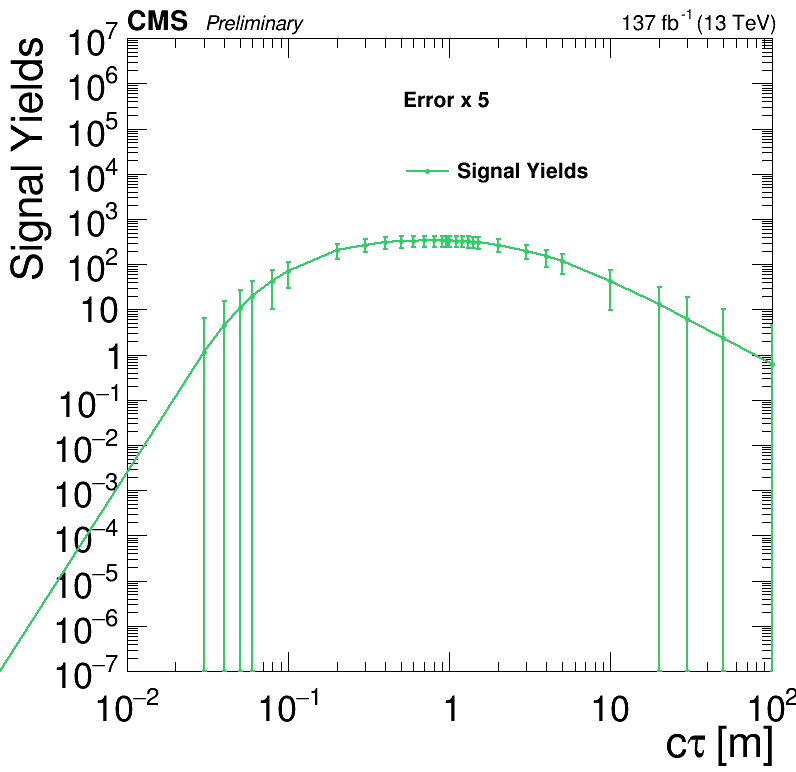

In [14]:
# plot 
rt.gStyle.SetOptFit(1011)    

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.5,0.73,0.80,0.92)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h_sig = rt.TGraphErrors(npts, ctaus_m, sig_bin2_sum_arr, ctaus_err, sig_bin2_sum_err_arr*5)


h_sig.SetTitle(" ; c#tau [m];Signal Yields");
leg.AddEntry(h_sig, "Signal Yields", "PL")
leg.SetHeader( "Error x 5")
h_sig.SetLineColor(845)
h_sig.SetLineWidth(2)
h_sig.SetMarkerColor(845)
h_sig.SetMarkerStyle(20)
h_sig.SetMarkerSize(0.5)
h_sig.GetXaxis().SetLimits(0.01,100.0)
h_sig.GetYaxis().SetRangeUser(1e-7,1e+7)
h_sig.GetXaxis().SetTitleOffset(1)

h_sig.Draw('ALPsame')

tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText = True
CMS_lumi.extraText   = "Preliminary"

iPos = 0
if( iPos==0 ): CMS_lumi.relPosX = 0.12
CMS_lumi.CMS_lumi(c, 4, 0)
leg.Draw()
c.SetRightMargin(0.03)
c.SetLogy()
c.SetLogx()

c.Draw()
# print(time.time()-start_t) 
# outDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/SignalYields/v1/'
outDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/SignalYields/v2/'

os.system("mkdir -p "+ outDir)
# c.SaveAs(outDir+'SignalYield.png')
c.SaveAs(outDir+'SignalYield_100m.png')


In [15]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v0/'

# os.system("mkdir -p "+ plotDir)
for ct in CTAUs:
    if sig_bin2_sum[str(ct)] >0:
        card_name = 'GMSB_LLP_m200_ctau'+str(ct)+'.txt'
        sig_unc = sig_bin2_sum_err[str(ct)] / sig_bin2_sum[str(ct)]
        sig_stat = 0.2
        bkg_unc = data_bin2_sum_err / data_bin2_sum
        bkg_pred = 0.5
        sig_yield = sig_bin2_sum[str(ct)]
        bkg_yield = data_bin2_sum
        make_datacard(plotDir, card_name, sig_yield, bkg_yield, sig_unc, sig_stat, bkg_unc, bkg_pred)
        print(plotDir+card_name)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau30.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau40.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau50.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau60.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau80.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau100.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau200.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau300.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau400.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau500.txt
/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau600.txt
/storage/user/j

In [16]:
for ct in CTAUs:
    card_name = 'GMSB_LLP_m200_ctau'+str(ct)+'.txt'
#     print(plotDir+card_name)
    print('combine -M AsymptoticLimits '+plotDir+card_name+' -n _GMSB_LLP_m200_ctau'+str(ct)+'  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_GMSB_LLP_m200_ctau'+str(ct)+'.txt' )


combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau1.txt -n _GMSB_LLP_m200_ctau1  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_GMSB_LLP_m200_ctau1.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau3.txt -n _GMSB_LLP_m200_ctau3  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_GMSB_LLP_m200_ctau3.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau5.txt -n _GMSB_LLP_m200_ctau5  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_GMSB_LLP_m200_ctau5.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP_m200_ctau7.txt -n _GMSB_LLP_m200_ctau7  --rMin 0.0 --rMax 1.0 -t -1 --expectSignal 0 -m 125 > limit_GMSB_LLP_m200_ctau7.txt
combine -M AsymptoticLimits /storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/DataCards/v3/GMSB_LLP

# Limit plot

In [27]:
# rtDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/GMSB_LLP_V1p17_v0/'
# rtDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/GMSB_LLP_V1p17_v1/'
# rtDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/GMSB_LLP_V1p17_v3/'
rtDir = '/storage/user/jmao/login-1/jmao/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/GMSB_LLP_V1p17_v4/'
rtFiles = {}
rtTrees = {}
Limits = {}
LimitErrs = {}
# CTAUs=np.array([  60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([  80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([ 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
CTAUs=np.array([ 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 50000, 100000])
for ct in CTAUs:
    rtName = 'higgsCombine_GMSB_LLP_m200_ctau'+str(ct)+'.AsymptoticLimits.mH125.root'
    print('ctau ', ct, ' mm')
#     print(rtName)
    rtFiles[str(ct)] = rtDir+rtName
    
    root_dir = uproot.open(rtFiles[str(ct)])
    rtTrees[str(ct)] = root_dir['limit']

    print( "-2\u03C3 , -\u03C3 , exp, +\u03C3 , +2\u03C3 , obs")
    v = rtTrees[str(ct)]
    limit = v['limit'].array()
    print(limit)
    limitErr = v['limitErr'].array()
    print(limitErr)
    
    Limits[str(ct)] = limit
    LimitErrs[str(ct)] = limitErr


ctau  30  mm
-2σ , -σ , exp, +σ , +2σ , obs
[ 2.78994131  4.38499832  8.02499962 16.14995003 24.33837509  8.03440469]
[0.         0.         0.         0.         0.         0.03435852]
ctau  40  mm
-2σ , -σ , exp, +σ , +2σ , obs
[0.60908204 0.88295746 1.44375002 2.59471989 4.37620544 1.44524023]
[0.         0.         0.         0.         0.         0.00423679]
ctau  50  mm
-2σ , -σ , exp, +σ , +2σ , obs
[0.24979249 0.35674858 0.56093752 0.94998777 1.61716568 0.56181087]
[0.         0.         0.         0.         0.         0.00167317]
ctau  60  mm
-2σ , -σ , exp, +σ , +2σ , obs
[0.1360382  0.19159441 0.29765624 0.48986447 0.81104577 0.29740468]
[0.         0.         0.         0.         0.         0.00065209]
ctau  80  mm
-2σ , -σ , exp, +σ , +2σ , obs
[0.060466   0.08493901 0.13007812 0.20992665 0.33899188 0.1299713 ]
[0.         0.         0.         0.         0.         0.00064363]
ctau  100  mm
-2σ , -σ , exp, +σ , +2σ , obs
[0.03625488 0.05102119 0.07734375 0.12420466 0.19

In [28]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

start_t = time.time()

# CTAUs=np.array([1,3,5,7, 10, 30, 40, 50, 60, 80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([  80, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([  80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 10000])
# CTAUs=np.array([ 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 950, 980, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 10000])
ctaus_m = CTAUs/1000
# npts = len(CTAUs)
npts = len(ctaus_m)
# print(npts)
# print(ctaus_m)
ctaus_2m = np.array(np.hstack((ctaus_m, np.flip(ctaus_m)))) 
# print(ctaus_2m)

# XSEC = 1e-03*1335.62*0.5824*0.5824 #pb
XSEC = 1 #pb

expL = []
exp1sigP = []
exp1sigM = []
exp2sigP = []
exp2sigM = []
for ct in CTAUs:
    ctau = str(ct)
    expL.append(Limits[ctau][2])
    exp1sigP.append(Limits[ctau][1])
    exp1sigM.append(Limits[ctau][3])
    exp2sigP.append(Limits[ctau][0])
    exp2sigM.append(Limits[ctau][4])
    
expL = np.array(expL)
expL1sigP= np.array(exp1sigP)
expL1sigM= np.array(exp1sigM)
expL2sigP= np.array(exp2sigP)
expL2sigM= np.array(exp2sigM)

# print(expL)
# print(exp1sigP)
# print(exp1sigM)
# print(exp2sigP)
# print(exp2sigM)

exp1sig = np.array(np.hstack((exp1sigP, np.flip(exp1sigM)))) 
exp2sig = np.array(np.hstack((exp2sigP, np.flip(exp2sigM)))) 

# print(exp1sig)
# print(exp2sig)

# print(expL)
print(XSEC, ' pb' )
# expL=expL*XSEC

expL*=XSEC
exp1sig*=XSEC
exp2sig*=XSEC

# print(expL)



1  pb


137 fb^{-1} (13 TeV)
5.3215272426605225


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/LimitPlots/v3/Limit_100m.png has been created


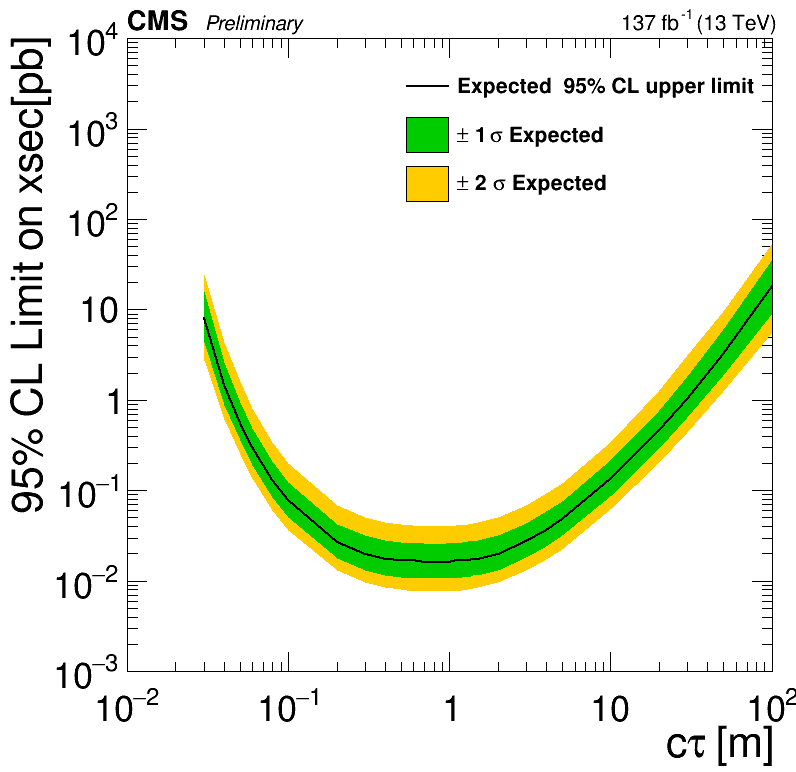

In [29]:

rt.gStyle.SetOptFit(1011)

# h_exp = {}
# h_exp1sig = {}
# h_exp2sig = {}


c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.5,0.73,0.80,0.92)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

h_exp = create_TGraph(ctaus_m, expL,  axis_title=['c#tau [m]', '95% CL Limit on xsec[pb]'])

h_exp1sig = create_TGraph(ctaus_2m,  exp1sig)
h_exp2sig = create_TGraph(ctaus_2m,  exp2sig)


leg.AddEntry(h_exp, "Expected  95% CL upper limit", "L")
leg.AddEntry(h_exp1sig, "#pm 1 #sigma Expected", 'F')
leg.AddEntry(h_exp2sig, "#pm 2 #sigma Expected", 'F')
h_exp.SetLineColor(1)
h_exp.SetLineWidth(2)
h_exp1sig.SetFillColor(417)
h_exp2sig.SetFillColor(800)
h_exp.GetXaxis().SetLimits(0.01,100.0)
h_exp.GetYaxis().SetRangeUser(1e-3,1e+4)
h_exp.GetXaxis().SetTitleOffset(1)

h_exp.Draw('LA')
h_exp2sig.Draw( 'Fsame')
h_exp1sig.Draw('Fsame')
h_exp.Draw('Lsame')

tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText = True
CMS_lumi.extraText   = "Preliminary"

iPos = 0
if( iPos==0 ): CMS_lumi.relPosX = 0.12
CMS_lumi.CMS_lumi(c, 4, 0)
leg.Draw()
c.SetRightMargin(0.03)
c.SetLogy()
c.SetLogx()

c.Draw()
print(time.time()-start_t) 
# LimDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/LimitPlots/v1/'
# LimDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/LimitPlots/v2/'
LimDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/LimitPlots/v3/'

os.system("mkdir -p "+ LimDir)
# c.SaveAs('/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/LimitPlots/v1/'+'Limit.png')
# c.SaveAs('/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/LimitPlots/v1/'+'Limit_morepts.png')
# c.SaveAs('/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/LimitPlots/v1/'+'Limit_100m.png')
# c.SaveAs('/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/LimitPlots/v2/'+'Limit_100m.png')
c.SaveAs('/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/LimitPlots/v3/'+'Limit_100m.png')
# 